In [136]:
%load_ext autoreload
import os,sys
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import progressbar
from datetime import datetime
sys.path.append("../")

print(sys.path)

%autoreload 2
from src.pySRM.pysrm.segment import IMZMLExtract, SpectraRegion, ProteinWeights, CombinedSpectra
from collections import Counter, defaultdict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/mnt/f/dev/git/pyIMS/examples', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/local/lib/python3.8/dist-packages/mpld3-0.3.1.dev1-py3.8.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/mjoppich/.ipython', '../', '../']


In [620]:
! ls /mnt/f/dev/data/msi/AL1_1

200213_AL1_1.ibd    200213_AL1_1.imzML.regions	200213_AL1_1_spotlist.txt
200213_AL1_1.imzML  200213_AL1_1_Plot.jpg


In [ ]:
imze = IMZMLExtract("/mnt/f/dev/data/msi/AL1_1/200213_AL1_1.imzML")

In [ ]:
plt.figure(figsize=(20, 8))
imze.list_regions()

In [ ]:
avg_region_spectrum = imze.get_avg_region_spectrum(2)
avg_region_spectrum_unit = avg_region_spectrum / np.linalg.norm(avg_region_spectrum)

In [ ]:
maxShift = 20
spectra_orig = imze.get_region_array(3, makeNullLine=True)

sh_sporig_nobg, sh_sporig_nobg_masses = imze.remove_background_spec_aligned(spectra_orig, avg_region_spectrum, imze.mzValues, maxShift)

sh_sporig_bg, sh_masses_sporig_bg = imze.shift_region_array(sh_sporig_nobg, sh_sporig_nobg_masses, maxShift)

In [ ]:
def plot_coords(arr, coords, valRange, xvals):
    plt.figure(figsize=(20, 6))
        
    for x in coords:
        plt.plot(xvals[valRange], arr[x][valRange], label=str(x))
    plt.legend()

In [ ]:
plot_coords(spectra_orig, [(20,15), (40,15), (60,15), (80,15)], range(8800,9200), imze.mzValues)

In [ ]:
plot_coords(sh_sporig_nobg, [(20,15), (40,15), (60,15), (80,15)], range(8800,9200), sh_sporig_nobg_masses)

In [ ]:
plot_coords(sh_sporig_bg, [(20,15), (40,15), (60,15), (80,15)], range(8800,9200), sh_masses_sporig_bg)

The shifted peaks seem to match better, and are optimized for cosine similarity.

In [ ]:
#spectra_intra = imze.normalize_region_array(spectra_orig, normalize="intra_median")

In [ ]:
#spectra_orig_nobg, spectra_orig_nobg_masses = imze.remove_background_spec_aligned(spectra_orig,avg_region_spectrum, imze.mzValues, 20)
#sh_sporig, sh_masses_sporig = imze.shift_region_array(spectra_orig_nobg, spectra_orig_nobg_masses, maxShift)

In [ ]:
#sh_sporig_bg = imze.normalize_region_array(spectra_intra, normalize="inter_median")

In [ ]:
#spectra_intra_inter_max = imze.normalize_region_array(sh_sporig_bg,normalize="max_intensity_spectrum")

In [ ]:
sh_sporig_bg_norm = imze.normalize_region_array(sh_sporig_bg, normalize="vector")

In [ ]:
plot_coords(sh_sporig_bg_norm, [(10,15), (20,15), (40,15), (60,15), (80,15)], range(8800,9200), sh_masses_sporig_bg)

In [ ]:
plot_coords(sh_sporig_bg_norm, [(10,15), (40,15)], range(8800,9200), sh_masses_sporig_bg)

In [ ]:
plot_coords([avg_region_spectrum_unit], [0], range(8800,9200), imze.mzValues)

Keep a copy of the originally normalized spectrum

In [ ]:
spectra = np.array(sh_sporig_bg_norm, copy=True)

This function calculates a diagonal (width 5) from top to bottom. The idea is, that if there is a target region and background in a MSI dataset, it will be included in this band

In [ ]:
def calc_band_pixels(spre):
    
    band_pixels = set()
    
    xmax = spre.shape[0]
    ymax = spre.shape[1]
    
    p2 = np.array([xmax, ymax])
    p1 = np.array([0,0])
    
    for i in range(spre.shape[0]):
        for j in range(spre.shape[1]):
            
            p3 = np.array([i,j])
            d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
            
            if d < 2:
                band_pixels.add((i,j))
                
    return band_pixels
    

This function calculates the differential masses for each spectrum comparison. Each spectrum from a testPixel is compared against each testAgainstPixel.

In [ ]:

def calculateDiffMasses( inSpectra, testPixels, testAgainstPixels, storeFCs = False):

    global_fcs = Counter()
    scalingFactor = 1000

    fcMassesCounter = Counter()
    masses2fcs = defaultdict(list)

    stdMul = 8

    bar = progressbar.ProgressBar(widgets=[
            progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
        ])

    pixel2demasses = defaultdict(set)
    
    for (k,l) in bar(testPixels):       
        
        for i in range(inSpectra.shape[0]):
            for j in range(inSpectra.shape[1]):

                if (k,l) == (i,j):
                    continue

                if not (i,j) in testAgainstPixels:
                    continue


                fcs = np.log( (inSpectra[i][j]+(1.0/scalingFactor)) / (inSpectra[k][l] +(1.0/scalingFactor)) )

                meanFCs = np.mean(fcs)
                stdFCs = np.std(fcs)

                maxFC = meanFCs + stdMul*stdFCs
                minFC = meanFCs - stdMul*stdFCs

                if len(fcMassesCounter) > 0 and len(fcMassesCounter) % 1000 == 0:
                    print("Masses: ", len(fcMassesCounter))

                for ifc, x in enumerate(fcs):                        
                    if x < minFC or x > maxFC:
                        fcMass = imze.mzValues[ifc]
                        fcMassesCounter[fcMass] += 1
                        
                        pixel2demasses[k,l].add(fcMass)
         
    print("Found", len(fcMassesCounter), "differential masses")
        
    if storeFCs:
        bar = progressbar.ProgressBar(widgets=[
                progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
            ])

        
        for (k,l) in bar(testPixels):       

            for i in range(inSpectra.shape[0]):
                for j in range(inSpectra.shape[1]):

                    if (k,l) == (i,j):
                        continue

                    if not (i,j) in testAgainstPixels:
                        continue


                    fcs = np.log( (inSpectra[i][j]+(1.0/scalingFactor)) / (inSpectra[k][l] +(1.0/scalingFactor)) )

                    meanFCs = np.mean(fcs)
                    stdFCs = np.std(fcs)

                    maxFC = meanFCs + stdMul*stdFCs
                    minFC = meanFCs - stdMul*stdFCs

                    for ifc, x in enumerate(fcs):

                        fcMass = imze.mzValues[ifc]

                        if fcMass in fcMassesCounter:
                            masses2fcs[fcMass].append(x)                      


    return fcMassesCounter, pixel2demasses, masses2fcs

                

In [624]:
def calculateDiffMassesEmpire( inSpectra, testPixels, testAgainstPixels):

    global_fcs = Counter()
    scalingFactor = 1000

    fcMassesCounter = Counter()
    masses2fcs = defaultdict(list)

    stdMul = 8

    bar = progressbar.ProgressBar(widgets=[
            progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
        ])
    
    deMassIndices = []

    for massIdx in bar(range(inSpectra.shape[2])):
        
        testValues = [inSpectra[k,l,massIdx] for (k,l) in testPixels]
        testAgainstValues = [inSpectra[k,l,massIdx] for (k,l) in testAgainstPixels]
        
        #deFcs = [1] * (len(testValues) * len(testAgainstValues))
        #valIdx = 0
        #for tval in testValues:
        #    for taval in testAgainstValues:
        #        fc = np.log( (tval+(1.0/scalingFactor)) / (taval +(1.0/scalingFactor)) )
            
        
        tFcs = [1] * (len(testValues) * len(testValues))
        valIdx = 0
        for tval in testValues:
            for taval in testValues:
                fc = np.log( (tval+(1.0/scalingFactor)) / (taval +(1.0/scalingFactor)) )
                
        taFcs = [1] * (len(testAgainstValues) * len(testAgainstValues))
        valIdx = 0
        for tval in testAgainstValues:
            for taval in testAgainstValues:
                fc = np.log( (tval+(1.0/scalingFactor)) / (taval +(1.0/scalingFactor)) )
    
        
        tMean = np.mean(tFcs)
        taMean = np.mean(taFcs)
        
        tStd = np.std(tFcs)
        taStd = np.std(taFcs)
        
        meanDist = abs(tMean-taMean)
        
        if meanDist > 2*tStd and meanDist > 2*taStd:
            #accept mass
            deMassIndices.append(massIdx)
            
    return deMassIndices
    


In [ ]:
import imageio
from sklearn import tree
from skimage.color import rgb2gray,rgba2rgb

In [ ]:
manual_mask = np.round(rgb2gray(rgba2rgb(imageio.imread("aorta_test_lipids.png"))))
plt.imshow(manual_mask)

In [ ]:
The manual mask contains a mask for the target region which we want to at least somehow separate.

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import random

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
spec_subset_de = SpectraRegion(spectra, sh_masses_sporig_bg, "mass_shift_unitnorm")

In [ ]:
We now want to find all shape == aorta pixels, and all background ones

In [ ]:
shapePixels = set()
bgPixels = set()

for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        
        if manual_mask[x,y] < 0.5:
            shapePixels.add((x,y))
        else:
            bgPixels.add((x,y))

In [ ]:
print("Included pixels", len(shapePixels), len(bgPixels))

testPixels_aorta = random.sample(shapePixels, 200)
testPixels_bg = random.sample(bgPixels, 200)

In [ ]:

values_train = []
classes_train = []

values_test = []
classes_test = []

for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        
        if (x,y) in testPixels_aorta:
            values_test.append(spectra[x,y,:])
            classes_test.append(1)
            continue           
        if (x,y) in testPixels_bg:
            values_test.append(spectra[x,y,:])
            classes_test.append(0)
            continue
        
        if manual_mask[x,y] >= 0.5:
            
            values_train.append(spectra[x,y,:])
            classes_train.append(0)
            
        else:
            
            values_train.append(spectra[x,y,:])
            classes_train.append(1)
        
        
print("Train size", len(values_train))
print("Test size", len(values_test))

In [ ]:
subsetIdx = random.sample([x for x in range(0, len(values_train))], 600)
subsetIdx = [x for x in range(0, len(values_train))]

values_train_sub = []
classes_train_sub = []

for sIdx in subsetIdx:
    values_train_sub.append( values_train[sIdx] )
    classes_train_sub.append( classes_train[sIdx] )
    
print("Subsetted", len(values_train_sub))

In [ ]:
print(Counter(classes_train_sub))

In [293]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display# load dataset


Now learn and evaluate the testPixels

In [294]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(values_train_sub, classes_train_sub)

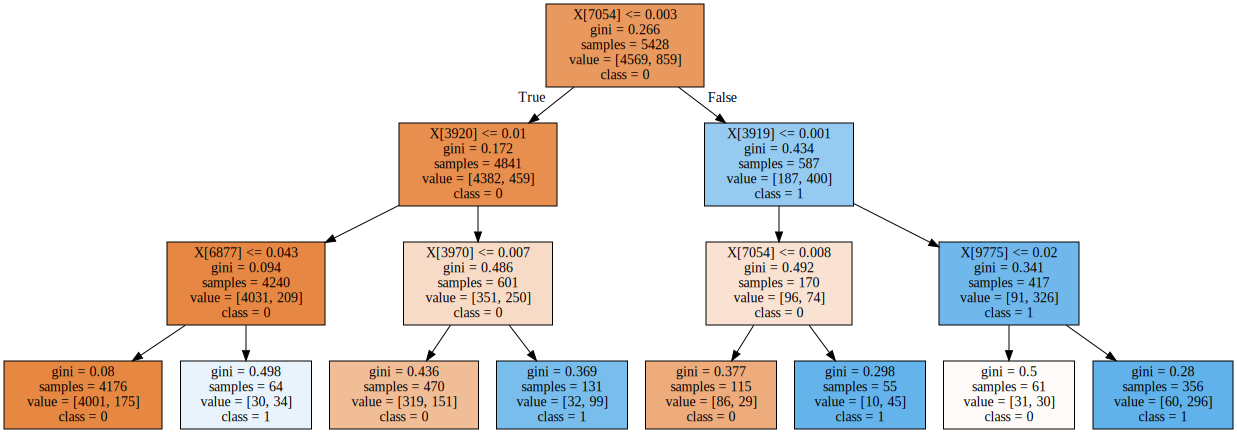

In [295]:
graph = Source(tree.export_graphviz(clf, out_file=None
   , class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

2020-09-23 10:52:00,847  SpectraRegion  INFO: Processing Mass 741.511439902798 with best existing mass 741.511439902798


7053 741.511439902798


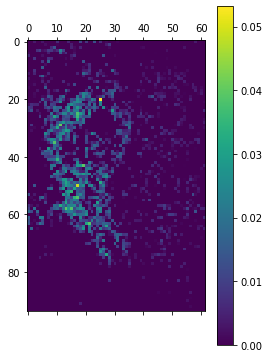

2020-09-23 10:52:01,018  SpectraRegion  INFO: Processing Mass 741.5511417902636 with best existing mass 741.5511417902636


7054 741.5511417902636


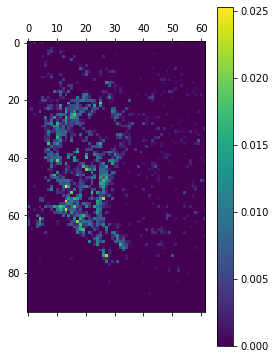

2020-09-23 10:52:01,140  SpectraRegion  INFO: Processing Mass 617.1254264732984 with best existing mass 617.1254264732984


3920 617.1254264732984


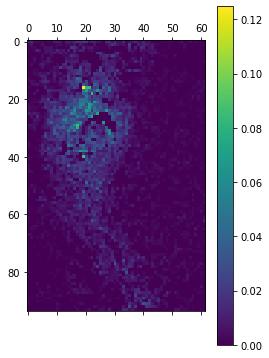

2020-09-23 10:52:01,262  SpectraRegion  INFO: Processing Mass 703.5564354857531 with best existing mass 703.5564354857531


6097 703.5564354857531


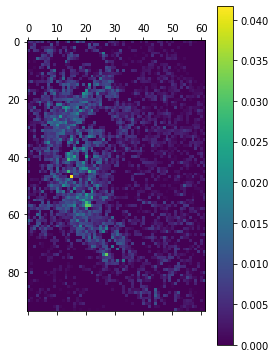

2020-09-23 10:52:01,396  SpectraRegion  INFO: Processing Mass 846.6420379115166 with best existing mass 846.6420379115166


9701 846.6420379115166


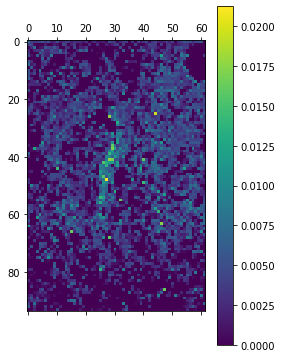

2020-09-23 10:52:01,523  SpectraRegion  INFO: Processing Mass 782.6425953170852 with best existing mass 782.6425953170852


8089 782.6425953170852


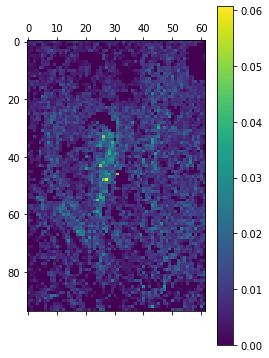

2020-09-23 10:52:01,651  SpectraRegion  INFO: Processing Mass 783.5160368413268 with best existing mass 783.5160368413268


8111 783.5160368413268


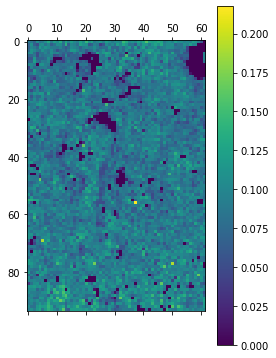

2020-09-23 10:52:01,779  SpectraRegion  INFO: Processing Mass 808.250312732351 with best existing mass 808.250312732351


8734 808.250312732351


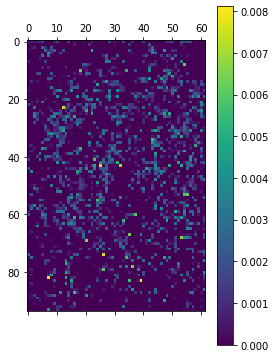

In [296]:
treeMasses = set()
for mzIdx in [7053,7054,3920,6097,9701,8089,8111,8734]:
    mzVal = spec_subset_de.idx2mass[mzIdx]
    
    print(mzIdx, mzVal)
    treeMasses.add(mzVal)
    spec_subset_de.mass_heatmap(mzVal)

2020-09-23 10:52:01,927  SpectraRegion  INFO: Processing Mass 567.537769 with best existing mass 567.5377690288537


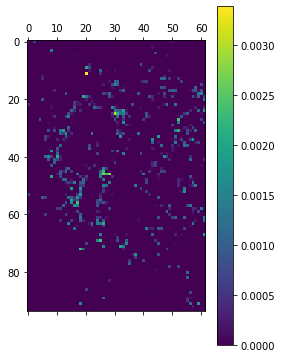

array([[0.        , 0.        , 0.00062039, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00184509, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [297]:
spec_subset_de.mass_heatmap(567.537769)

In [298]:
trueRate = 0
for value, label in zip(values_test, classes_test):
    retVal = clf.predict_proba([value])[0]
    pred_label = np.argmax(retVal)
    #print(label, pred_label, label==pred_label)
    
    if label==pred_label:
        trueRate += 1
        
print(trueRate, trueRate / len(classes_test))

280 0.7


In [ ]:
Given the ok-ish true positive rate, let's check what that means for the full image:

5191 5828 0.8907000686341798


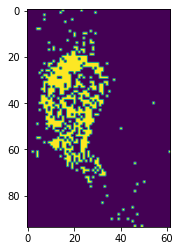

In [299]:
trues = np.zeros((spectra.shape[0], spectra.shape[1]))

trueEvals = 0

for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        
        
        retVal = clf.predict_proba([ spectra[x,y,:] ])[0]
        pred_label = np.argmax(retVal)
        
        if pred_label == 1:
            trues[x,y] = 1
            
        if pred_label == 1-manual_mask[x,y]:
            trueEvals += 1
            
print(trueEvals, spectra.shape[0]*spectra.shape[1], trueEvals / (spectra.shape[0]*spectra.shape[1]))
plt.imshow(trues)
        

That does not look too bad. Apparently it is possible to learn the difference.

The combination of multiple masses can be used to divide the data ... but is there any single mass, that can do the same?

Actually I don't remember anymore why we do this ...

In [302]:
def eval_mass(mass, intens, comp, spectra, manual):
    #bg if comp True
    
    correct = 0
    wrong = 0

    for x in range(0, spectra.shape[0]):
        for y in range(0, spectra.shape[1]):
            
            pred = 1 if comp(spectra[x,y,mass], intens) else 0
            
            if pred == manual[x,y]:
                correct += 1 
            else:
                wrong += 1
                    
    correct /= (spectra.shape[0]*spectra.shape[1])
    wrong /= (spectra.shape[0]*spectra.shape[1])
    return correct, wrong

In [301]:
eval_mass(mass=3943, intens=0.007, comp=lambda x,y: x<y, spectra=spectra, manual=manual_mask)

(0.8184625943719973, 0.18153740562800275)

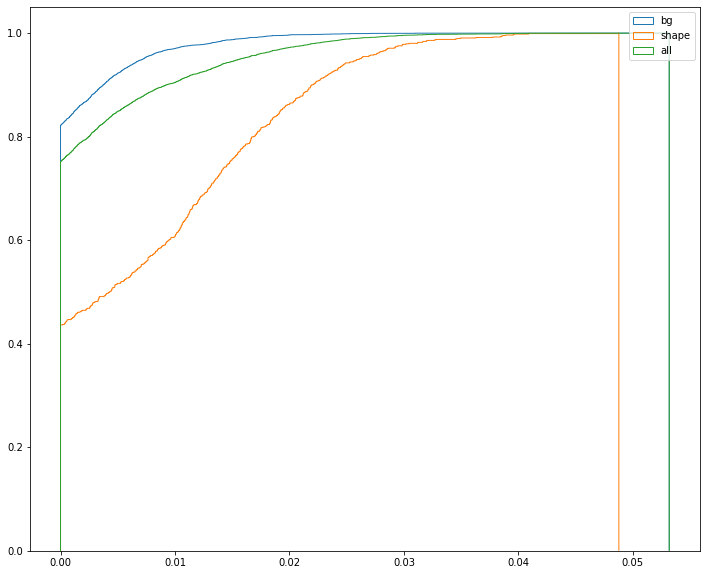

bg 0.0 [0.         0.         0.00373559 0.01621606] 0.05317520425000629
shape 0.0 [0.0129751  0.01680193 0.02196481 0.03479419] 0.048774697874210876
all 0.0 [0.         0.00250308 0.00925449 0.02590424] 0.05317520425000629


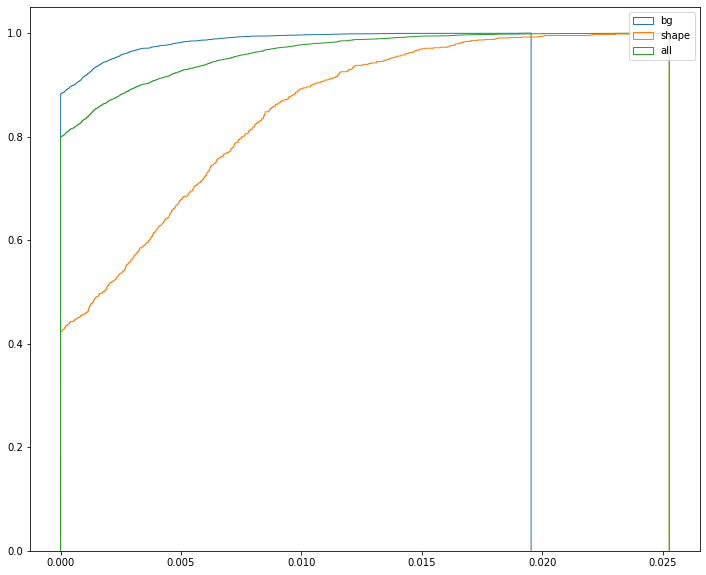

bg 0.0 [0.         0.         0.00056567 0.00672633] 0.01953900975969779
shape 0.0 [0.00553122 0.00756525 0.01044229 0.01812154] 0.02527379579370638
all 0.0 [0.00000000e+00 4.51257573e-05 3.35008117e-03 1.36251034e-02] 0.02527379579370638


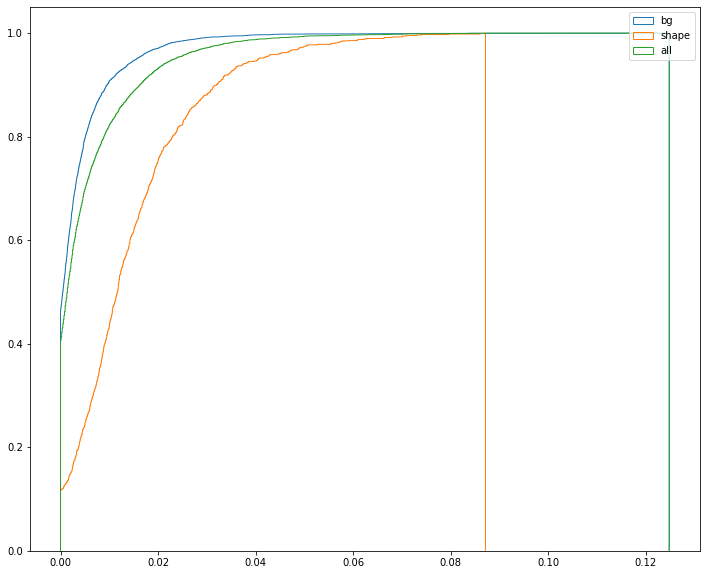

bg 0.0 [0.00304838 0.0051217  0.00955882 0.02860619] 0.12478835473994736
shape 0.0 [0.0180571  0.02299779 0.03197873 0.06431517] 0.08711323000057362
all 0.0 [0.00512334 0.00897733 0.01630033 0.04304762] 0.12478835473994736


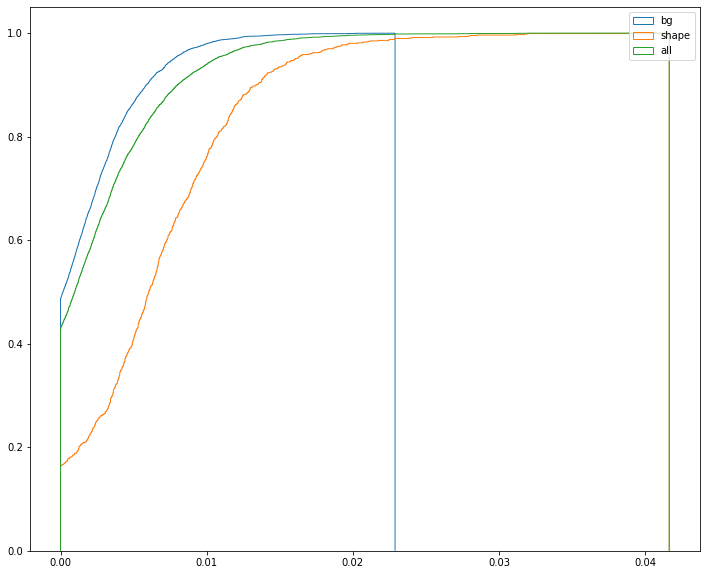

bg 0.0 [0.00245567 0.00374304 0.00586923 0.01199875] 0.022887091188168177
shape 0.0 [0.00895851 0.01071489 0.01339817 0.02330848] 0.04164757992143175
all 0.0 [0.00357141 0.00534919 0.00802422 0.01635262] 0.04164757992143175


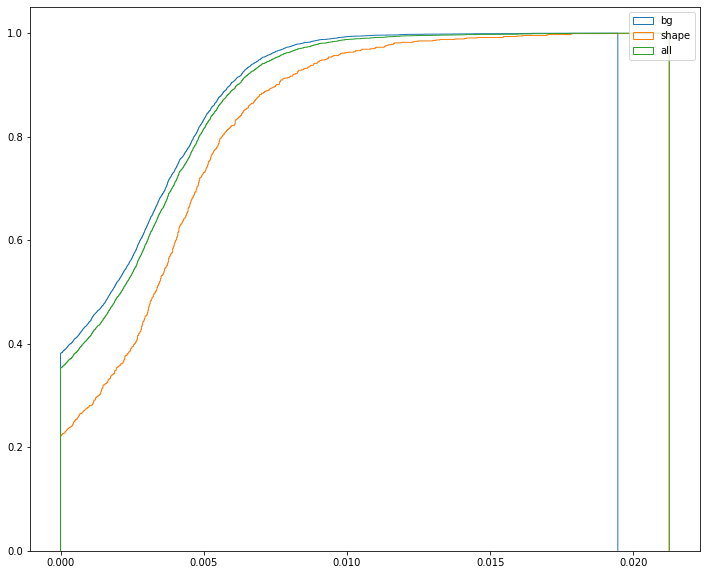

bg 0.0 [0.0036652  0.00466831 0.00592917 0.00954973] 0.019457480305987263
shape 0.0 [0.00475979 0.00564426 0.00753181 0.01414035] 0.021252972870775773
all 0.0 [0.00390309 0.00484473 0.00618416 0.01060882] 0.021252972870775773


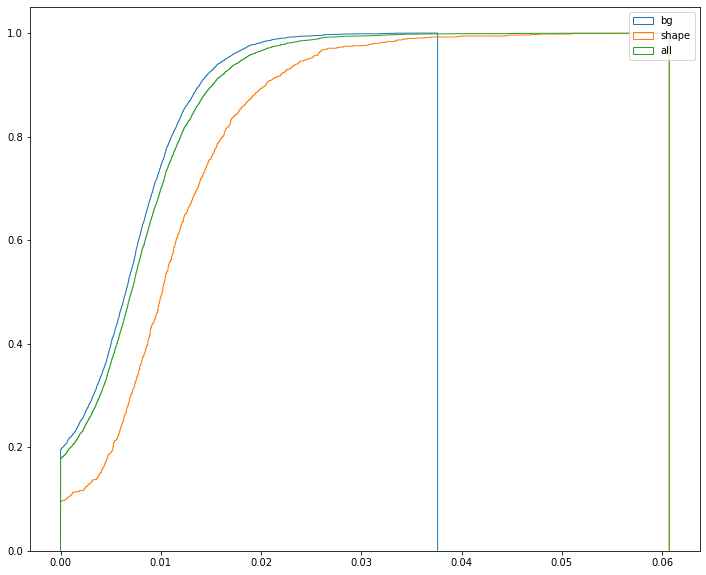

bg 0.0 [0.0092643  0.01107115 0.01388303 0.02194423] 0.037615785561040414
shape 0.0 [0.01371218 0.01620133 0.02048719 0.03506016] 0.06071952327635175
all 0.0 [0.01005933 0.01201288 0.01521266 0.02585419] 0.06071952327635175


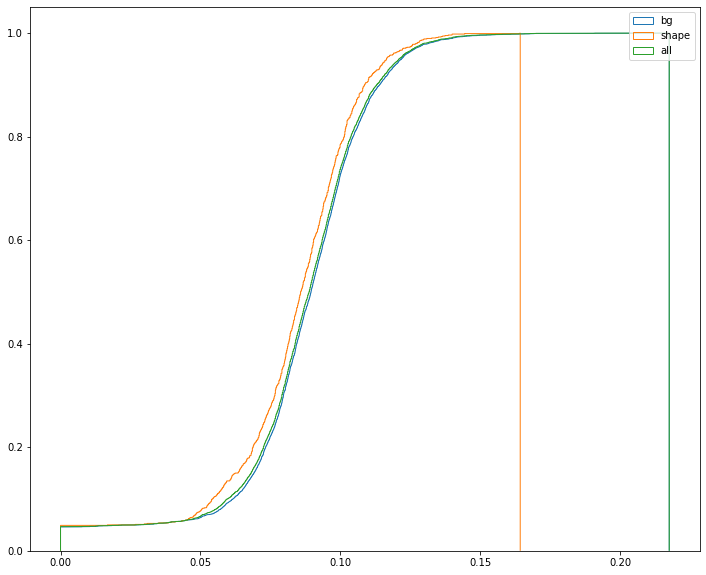

bg 0.0 [0.09891667 0.10457692 0.11405331 0.14010877] 0.21753511518259172
shape 0.0 [0.09584653 0.1014703  0.10873136 0.13169309] 0.16428319889469353
all 0.0 [0.09829765 0.10386875 0.11308767 0.13870098] 0.21753511518259172


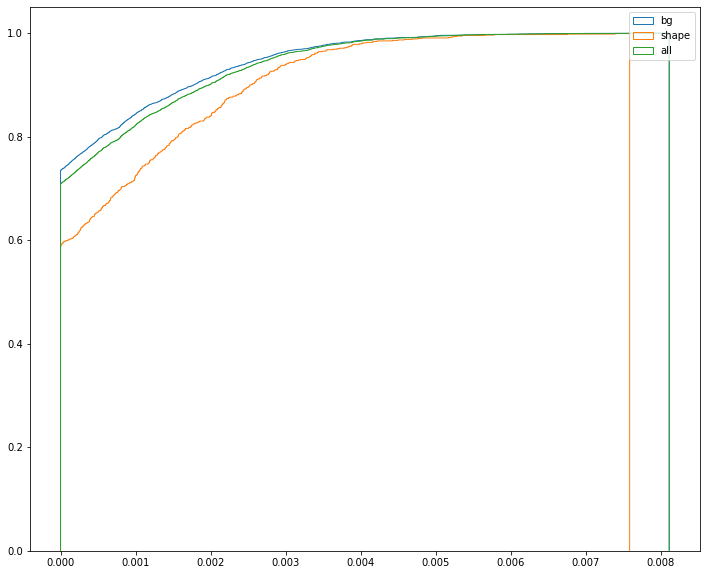

bg 0.0 [0.         0.00055944 0.00177807 0.00433256] 0.008112589666128255
shape 0.0 [0.00081036 0.00156429 0.00252978 0.00479039] 0.007584558808490913
all 0.0 [0.         0.00080893 0.00198442 0.00447944] 0.008112589666128255


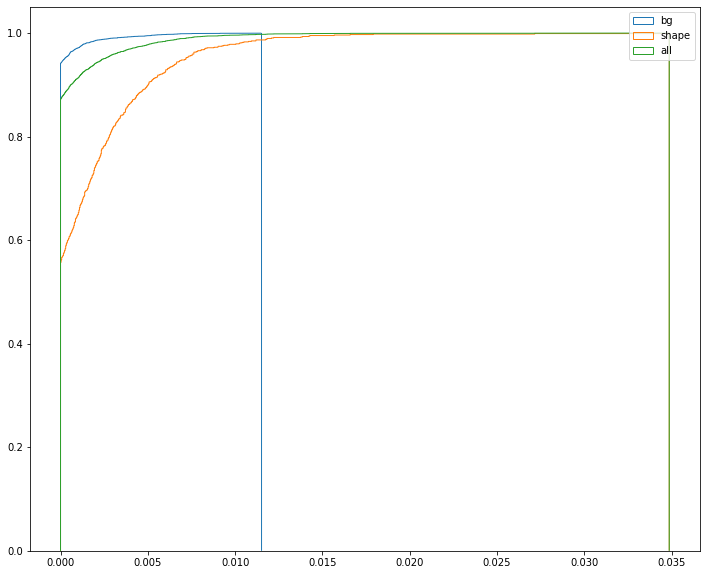

bg 0.0 [0.         0.         0.         0.00286759] 0.011514333737114631
shape 0.0 [0.00157819 0.00281167 0.00503253 0.01195879] 0.03486556254202373
all 0.0 [0.         0.         0.00060052 0.00720237] 0.03486556254202373


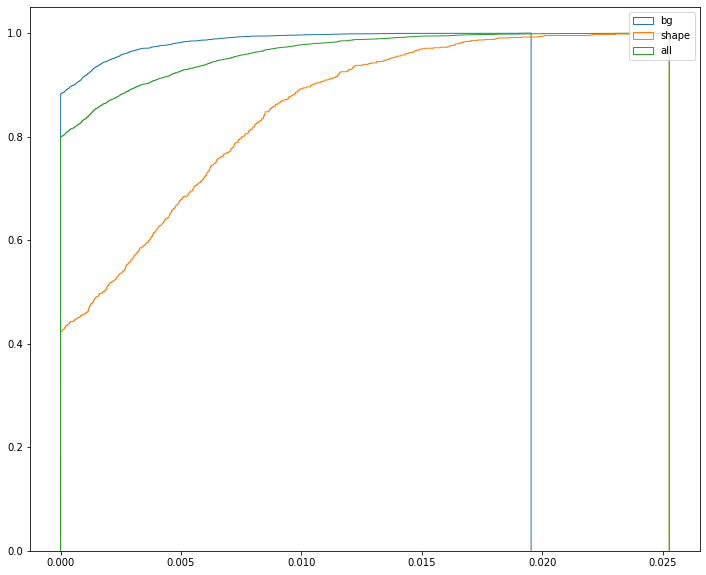

bg 0.0 [0.         0.         0.00056567 0.00672633] 0.01953900975969779
shape 0.0 [0.00553122 0.00756525 0.01044229 0.01812154] 0.02527379579370638
all 0.0 [0.00000000e+00 4.51257573e-05 3.35008117e-03 1.36251034e-02] 0.02527379579370638


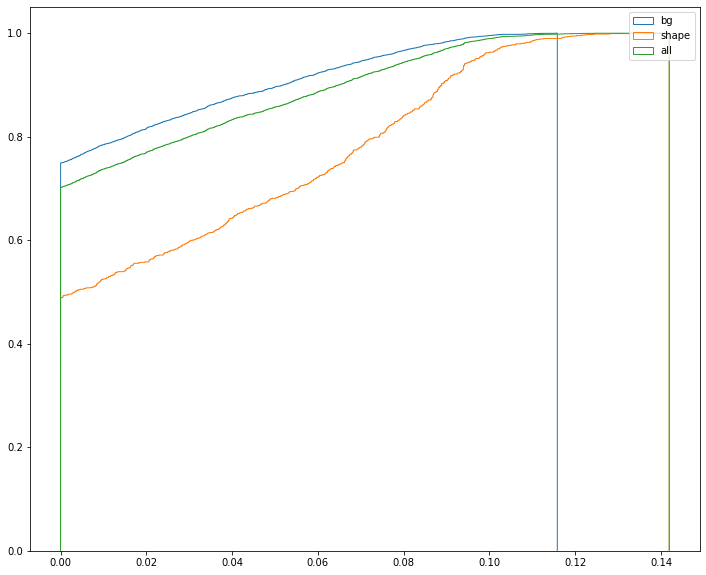

bg 0.0 [0.         0.01551415 0.0518895  0.09425342] 0.11580884086858428
shape 0.0 [0.05521813 0.07433605 0.08887653 0.1144222 ] 0.14190446314278662
all 0.0 [0.         0.03004976 0.06500767 0.10090037] 0.14190446314278662


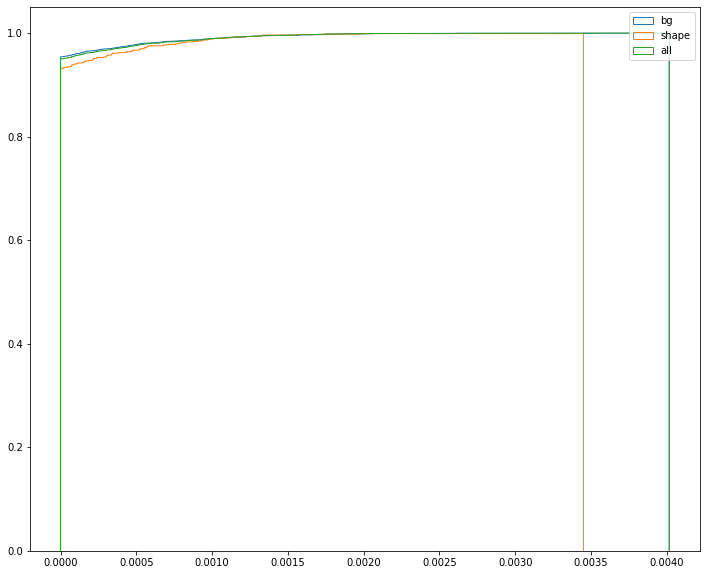

bg 0.0 [0.         0.         0.         0.00102415] 0.004016298315553954
shape 0.0 [0.         0.         0.         0.00103218] 0.0034500170879196
all 0.0 [0.         0.         0.         0.00102647] 0.004016298315553954


In [602]:
for mass in [7053,7054,3920,6097,9701,8089,8111,8734]+[3969,7054,3798,5000]:
    
    bgValues = [spectra[x,y,mass] for (x,y) in bgPixels]
    shapeValues = [spectra[x,y,mass] for (x,y) in shapePixels]
    mpl.rcParams['figure.figsize'] = (12,10)

    plt.figure()
    plt.hist(bgValues, histtype="step", cumulative=True, density=True, bins=len(bgValues), label="bg")
    plt.hist(shapeValues, histtype="step", cumulative=True, density=True, bins=len(shapeValues), label="shape")
    plt.hist(shapeValues+bgValues, histtype="step", cumulative=True, density=True, bins=len(shapeValues), label="all")
    plt.legend()
    plt.show()
    plt.close()
    showPerc = [70,80,90,99]
    print("bg", min(bgValues),  np.percentile(bgValues, showPerc), max(bgValues))
    print("shape",min(shapeValues),  np.percentile(shapeValues, showPerc), max(shapeValues))
    print("all",min(shapeValues+bgValues),  np.percentile(shapeValues+bgValues, showPerc), max(shapeValues+bgValues))


In [503]:
percentileMassIndices = []

bar = progressbar.ProgressBar(widgets=[
        progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
    ])

for mass in bar(range(0, spectra.shape[2])):
    
    bgValues = [spectra[x,y,mass] for (x,y) in bgPixels]
    shapeValues = [spectra[x,y,mass] for (x,y) in shapePixels]
    
    bgMean = np.mean(bgValues)
    shapeMean = np.mean(shapeValues)
    
    #intenseThreshold = (bgMean + shapeMean) / 2.0
    #ec, ew = 0,0# eval_mass(mass, intens=intenseThreshold, comp=lambda x,y: x<y, spectra=spectra, manual=manual_mask)
    
    pcVals = np.percentile(bgValues+shapeValues, [85, 99])
    
    if pcVals[1]-pcVals[0] > 0.01 and pcVals[0] < 0.0001:
        percentileMassIndices.append(mass)
        
        if len(percentileMassIndices) > 0 and len(percentileMassIndices) % 10 == 0:
            print("masses", len(percentileMassIndices))
        

    
print("Found percentile masses", len(percentileMassIndices))

|#####                                                    |   9% ETA:   0:02:23

masses 10


|#######                                                  |  12% ETA:   0:02:28

masses 20


|########                                                 |  15% ETA:   0:02:19

masses 30


|##########                                               |  18% ETA:   0:02:07

masses 40
masses 50


|############                                             |  21% ETA:   0:02:06

masses 60


|#############                                            |  24% ETA:   0:01:59

masses 70


|###############                                          |  27% ETA:   0:01:53

masses 80


|##################                                       |  32% ETA:   0:01:45

masses 90


|#########################################################| 100% Time:  0:02:41


Found percentile masses 92


In [475]:
percentileMassIndices

[1557,
 2663,
 2665,
 2666,
 2667,
 2688,
 2691,
 2714,
 2715,
 3772,
 3775,
 3797,
 3800,
 3823,
 3824,
 3896,
 3919,
 3920,
 3921,
 4180,
 4880,
 4881,
 4883,
 4884,
 4885,
 4906,
 4907,
 4908,
 4909,
 4932,
 4933,
 5989,
 5990,
 5991,
 5992,
 5993,
 5994,
 6015,
 6016,
 6017,
 6018,
 6019,
 6041,
 6042,
 6043,
 7052,
 7053,
 7098,
 7099,
 7100,
 7101,
 7102,
 7103,
 7104,
 7124,
 7125,
 7126,
 7127,
 7128,
 7150,
 7151,
 8161,
 8207,
 8208,
 8209,
 8210,
 8211,
 8233,
 8234,
 8235,
 8236,
 8237,
 9316,
 9318,
 9319,
 9320,
 9321,
 9342,
 9343,
 9344,
 9670,
 9721,
 9746,
 10427,
 10428,
 10429,
 10430,
 10453,
 10454,
 11537,
 11538,
 11561,
 12647]

In [607]:
percentileMassIndices = [3969 , 7054]

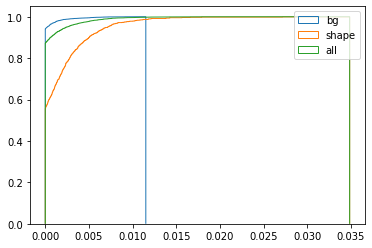

bg 0.0 [0.         0.         0.         0.00286759] 0.011514333737114631
shape 0.0 [0.00157819 0.00281167 0.00503253 0.01195879] 0.03486556254202373
all 0.0 [0.         0.         0.00060052 0.00720237] 0.03486556254202373


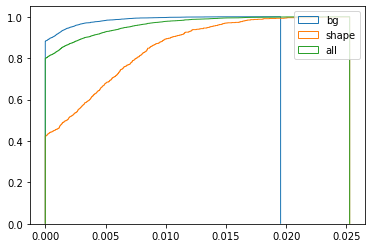

bg 0.0 [0.         0.         0.00056567 0.00672633] 0.01953900975969779
shape 0.0 [0.00553122 0.00756525 0.01044229 0.01812154] 0.02527379579370638
all 0.0 [0.00000000e+00 4.51257573e-05 3.35008117e-03 1.36251034e-02] 0.02527379579370638


In [446]:
for mass in percentileMassIndices:#[3969 , 7054, 3798,5000 ]:
    
    bgValues = [spectra[x,y,mass] for (x,y) in bgPixels]
    shapeValues = [spectra[x,y,mass] for (x,y) in shapePixels]
    
    plt.figure()
    plt.hist(bgValues, histtype="step", cumulative=True, density=True, bins=len(bgValues), label="bg")
    plt.hist(shapeValues, histtype="step", cumulative=True, density=True, bins=len(shapeValues), label="shape")
    plt.hist(shapeValues+bgValues, histtype="step", cumulative=True, density=True, bins=len(shapeValues), label="all")
    plt.legend()
    plt.show()
    plt.close()
    showPerc = [70,80,90,99]
    print("bg", min(bgValues),  np.percentile(bgValues, showPerc), max(bgValues))
    print("shape",min(shapeValues),  np.percentile(shapeValues, showPerc), max(shapeValues))
    print("all",min(shapeValues+bgValues),  np.percentile(shapeValues+bgValues, showPerc), max(shapeValues+bgValues))


2020-09-23 15:35:49,627  SpectraRegion  INFO: Processing Mass 619.0708189591093 with best existing mass 619.0708189591093


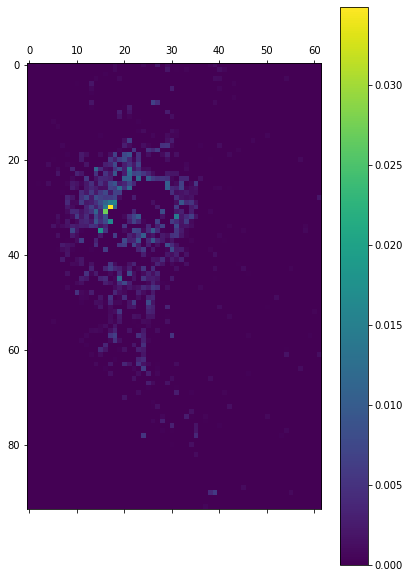

2020-09-23 15:35:49,772  SpectraRegion  INFO: Processing Mass 741.5511417902636 with best existing mass 741.5511417902636


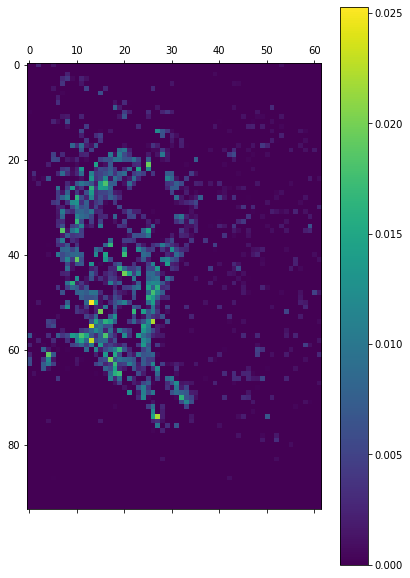

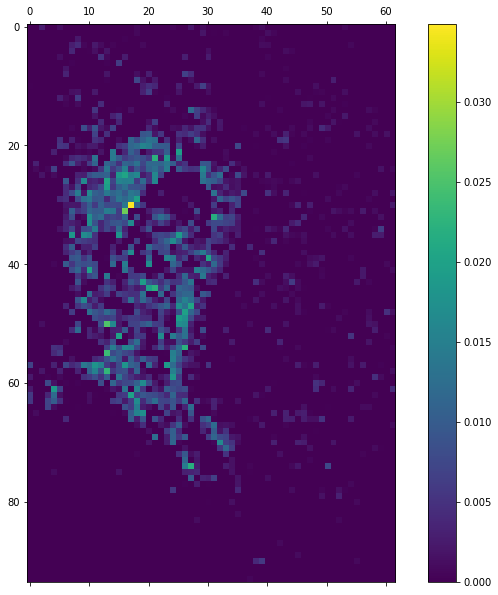

array([[0.        , 0.        , 0.00275187, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [604]:
mzVals = set()
for mzIdx in [3969 , 7054]:
    mzVal = spec_subset_de.idx2mass[mzIdx]
    mzVals.add(mzVal)
    spec_subset_de.mass_heatmap(mzVal)

spec_subset_de.plot_tic(mzVals)

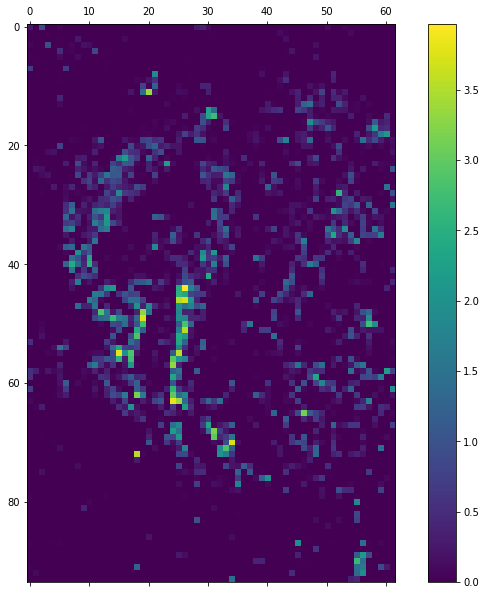

array([[2.61432642e-01, 4.79077858e-04, 8.92940480e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.12281923e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.74427137e-02, 0.00000000e+00, 0.00000000e+00, ...,
        8.79694123e-01, 2.85706548e-01, 0.00000000e+00],
       [0.00000000e+00, 8.95113457e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [603]:
percentileMZs = [spec_subset_de.idx2mass[mzIdx] for mzIdx in percentileMassIndices]
spec_subset_de.plot_tic(percentileMZs)

Apply the percentile method to the spectra

In [608]:
print(spectra.shape, sh_sporig_bg_norm.shape)

(94, 62, 38720) (94, 62, 38720)


In [609]:
fcIndices = percentileMassIndices

percentile_peaks = spectra[:,:,fcIndices]
percentile_masses = sh_masses_sporig_bg[fcIndices]

percentile_masses.shape

(2,)

In [610]:
spec_percentile = SpectraRegion(percentile_peaks, percentile_masses)

In [611]:
spec_percentile.calculate_similarity(mode="spectra_log")

2020-09-23 15:43:42,159  SpectraRegion  INFO: Creating C++ obj
2020-09-23 15:43:42,160  SpectraRegion  INFO: 2 (94, 62, 2)
2020-09-23 15:43:42,161  SpectraRegion  INFO: dimensions 2
2020-09-23 15:43:42,161  SpectraRegion  INFO: input dimensions (94, 62, 2)
2020-09-23 15:43:42,162  SpectraRegion  INFO: Switching to dot mode
2020-09-23 15:43:42,163  SpectraRegion  INFO: Starting calc similarity c++
2020-09-23 15:43:42,270  SpectraRegion  INFO: outclust dimensions (5828, 5828)
2020-09-23 15:43:42,271  SpectraRegion  INFO: Calculating spectra similarity


2


2020-09-23 15:43:42,465  SpectraRegion  INFO: Calculating spectra similarity done


array([[1., 1., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.]], dtype=float32)

In [612]:
spec_percentile.segment(method="WARD", number_of_regions=5)

2020-09-23 15:43:43,958  SpectraRegion  INFO: Calculating clusters
2020-09-23 15:43:44,654  SpectraRegion  INFO: Calculating clusters done
2020-09-23 15:43:44,665  SpectraRegion  INFO: Calculating clusters saved


array([[1, 1, 2, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int16)

In [511]:
spec_percentile.filter_clusters(method='remove_singleton')
spec_percentile.filter_clusters(method='merge_background', bg_x=1, bg_y=1)
spec_percentile.filter_clusters(method='remove_islands')

2020-09-23 13:05:36,332  SpectraRegion  INFO: Assigning clusters to background: {1, 2}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

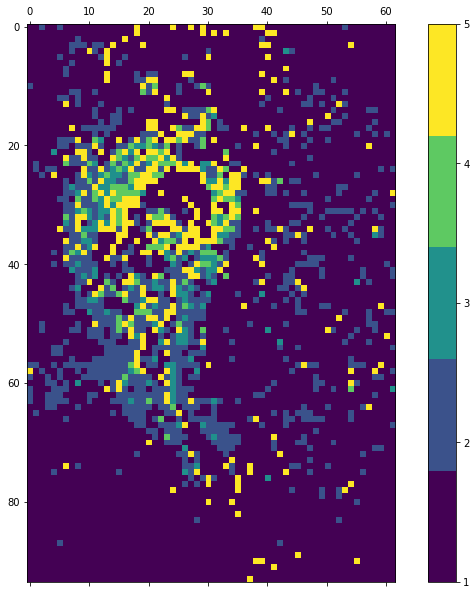

In [613]:
spec_percentile.plot_segments()

In [151]:
import hdbscan, umap

In [614]:
spec_percentile.segment(method="UMAP_DBSCAN",number_of_regions=None,min_cluster_size=5, min_samples=None, n_neighbors=15)

2020-09-23 15:44:36,670  SpectraRegion  INFO: Calculating clusters
2020-09-23 15:44:36,676  SpectraRegion  INFO: UMAP reduction


Elem Matrix (5828, 2)


2020-09-23 15:44:49,040  SpectraRegion  INFO: HDBSCAN reduction
2020-09-23 15:44:49,151  SpectraRegion  INFO: Calculating clusters done
2020-09-23 15:44:49,156  SpectraRegion  INFO: Calculating clusters saved


array([[ 2,  2, 21, ...,  2,  2,  2],
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 2,  2,  2, ...,  2,  2,  2],
       ...,
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 2,  2,  2, ...,  2,  2,  2]], dtype=int16)

0.0 0.96875
5828
196


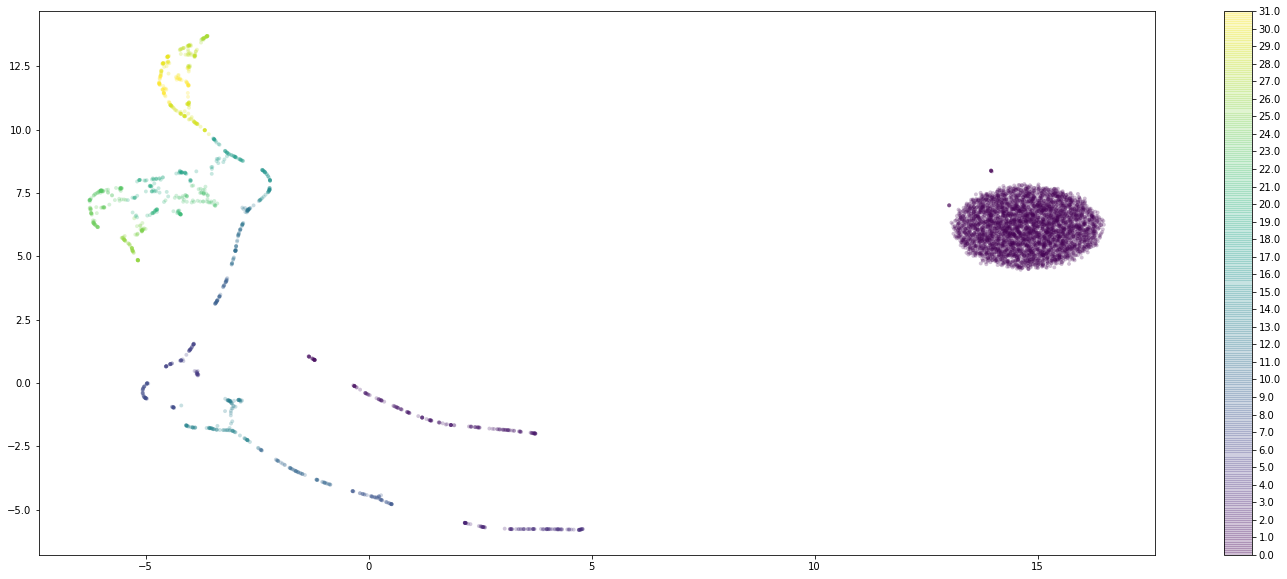

In [615]:
projection = spec_percentile.dimred_elem_matrix#umap.UMAP().fit_transform(spec_percentile.dimred_elem_matrix)

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True,gen_min_span_tree=True).fit(spec_percentile.dimred_elem_matrix)

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

cluster_labels = [np.argmax(x) for x in soft_clusters]

uniqueLabels = sorted(set(cluster_labels))
numLabels = len(cluster_labels)

cluster_colors = [x/len(uniqueLabels) for x in cluster_labels]

mpl.rcParams['figure.figsize'] = (25,10)
sp = plt.scatter(*projection.T, s=15, linewidth=0, c=cluster_colors, cmap="viridis", alpha=0.25)

valid_vals = np.unique(cluster_colors)
min_ = min(valid_vals)
max_ = max(valid_vals)

print(min_, max_)

positions = np.linspace(min_, max_, len(valid_vals))
val_lookup = dict(zip(positions, valid_vals))

def formatter_func(x, pos):
    'The two args are the value and tick position'
    val = val_lookup[x] * len(valid_vals)
    return val

formatter = plt.FuncFormatter(formatter_func)
plt.colorbar(sp, ticks=positions, format=formatter, spacing='proportional')

mpl.rcParams['figure.figsize'] = (6,4)

print(numLabels)
print(sum(clusterer.labels_ == -1))


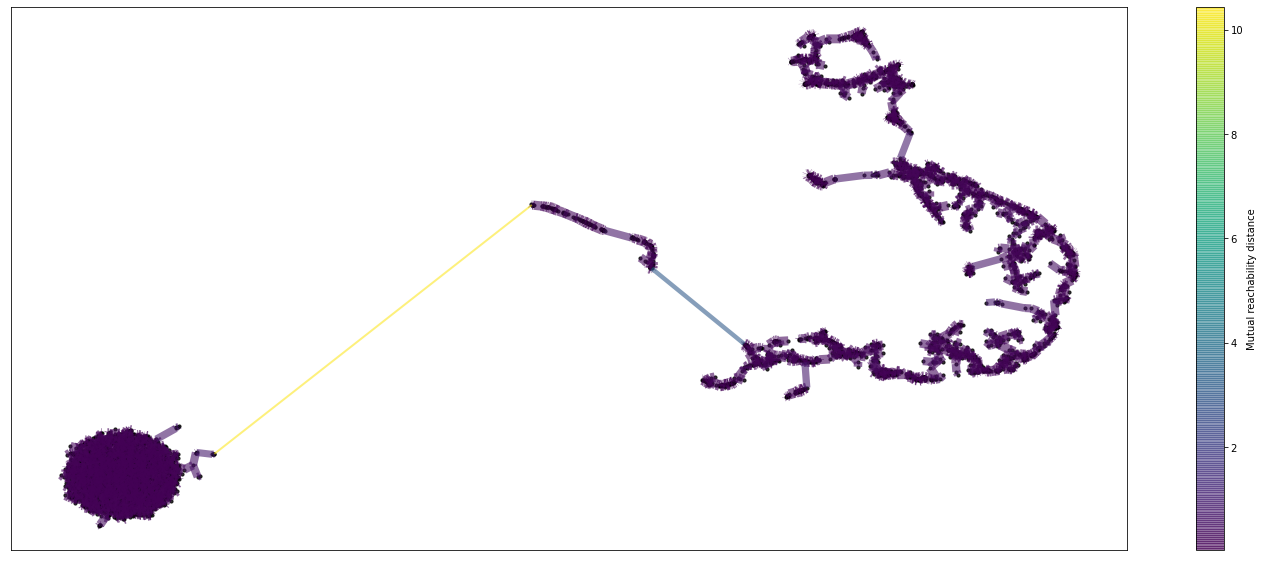

In [458]:
mpl.rcParams['figure.figsize'] = (25,10)

clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=10,
                                      edge_linewidth=2)
mpl.rcParams['figure.figsize'] = (6,4)


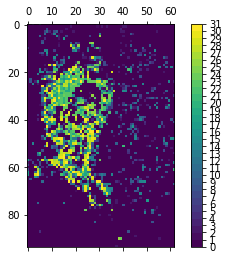

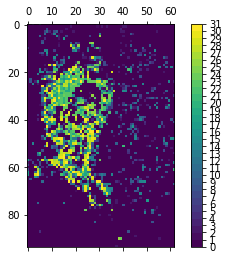

In [616]:
hdblabels = np.reshape(cluster_labels, (94,62))
spec_percentile.plot_array(plt.figure(), hdblabels)

In [395]:
def evalClusters( incluster ):
    corr = 0
    corrShape = 0
    incorr = 0
    for i in range(0, hdblabels.shape[0]):
        for j in range(0, hdblabels.shape[1]):

            if manual_mask[i,j] == 0 and hdblabels[i,j] in incluster:
                corr += 1
                corrShape += 1
            elif manual_mask[i,j] == 1 and not hdblabels[i,j] in incluster:
                corr += 1
            else:
                incorr += 1
    corrRatio = corr / (manual_mask.shape[0]*manual_mask.shape[1])
    incorrRatio = incorr / (manual_mask.shape[0]*manual_mask.shape[1])
    corrShape = corrShape / (manual_mask.shape[0]*manual_mask.shape[1])
    
    return corrShape, corrRatio, incorrRatio

In [393]:


#manual_mask==1 for bg, ==0 for shape
use_clusters = cluster_labels
for r in range(5):
    print("r=", r)
    
    max_ratio = 0
    max_elems = None
    
    for shapeCluster in itertools.combinations(np.unique(use_clusters), r):
        
        corrShape, corrRatio, incorrRatio = evalClusters(shapeCluster)
        
        if corrShape > max_ratio:
            max_ratio = corrShape
            max_elems = shapeCluster
        
        if corrRatio > 0.85:
            print(shapeCluster, corrShape, corrRatio, incorr / (corr+incorr) )
            
    print(r, max_ratio, max_elems)

r= 0
0 0 None
r= 1
1 0.05490734385724091 (3,)
r= 2
2 0.08030199039121483 (3, 25)
r= 3


KeyboardInterrupt: 

In [399]:
evalClusters([x for x in cluster_labels if not x in [3,25]])

(0.1014070006863418, 0.7137954701441318, 0.2862045298558682)

(0.08339052848318462, 0.8824639670555937, 0.11753603294440632)


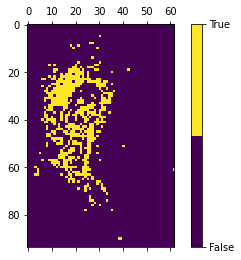

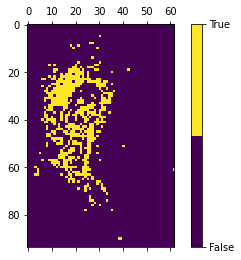

In [619]:
clusterDef = [x for x in cluster_labels if 17 < x < 32]
#clusterDef = [0]
print(evalClusters(clusterDef))
spec_percentile.plot_array(plt.figure(), np.isin(hdblabels,clusterDef))

In [305]:
import itertools

In [524]:
spec_percentile.segmented = hdblabels

2020-09-23 17:35:17,072  SpectraRegion  INFO: Calculating consensus spectra
2020-09-23 17:35:17,083  SpectraRegion  INFO: Calculating consensus spectra done


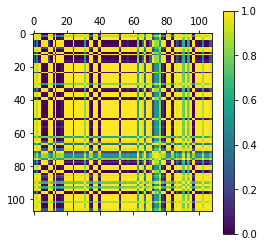

In [621]:
spec_percentile.consensus_spectra()
spec_percentile.consensus_similarity()
spec_percentile.plot_consensus_similarity()

Dimred Shape (5828, 2)
Unassigned (439, 2)


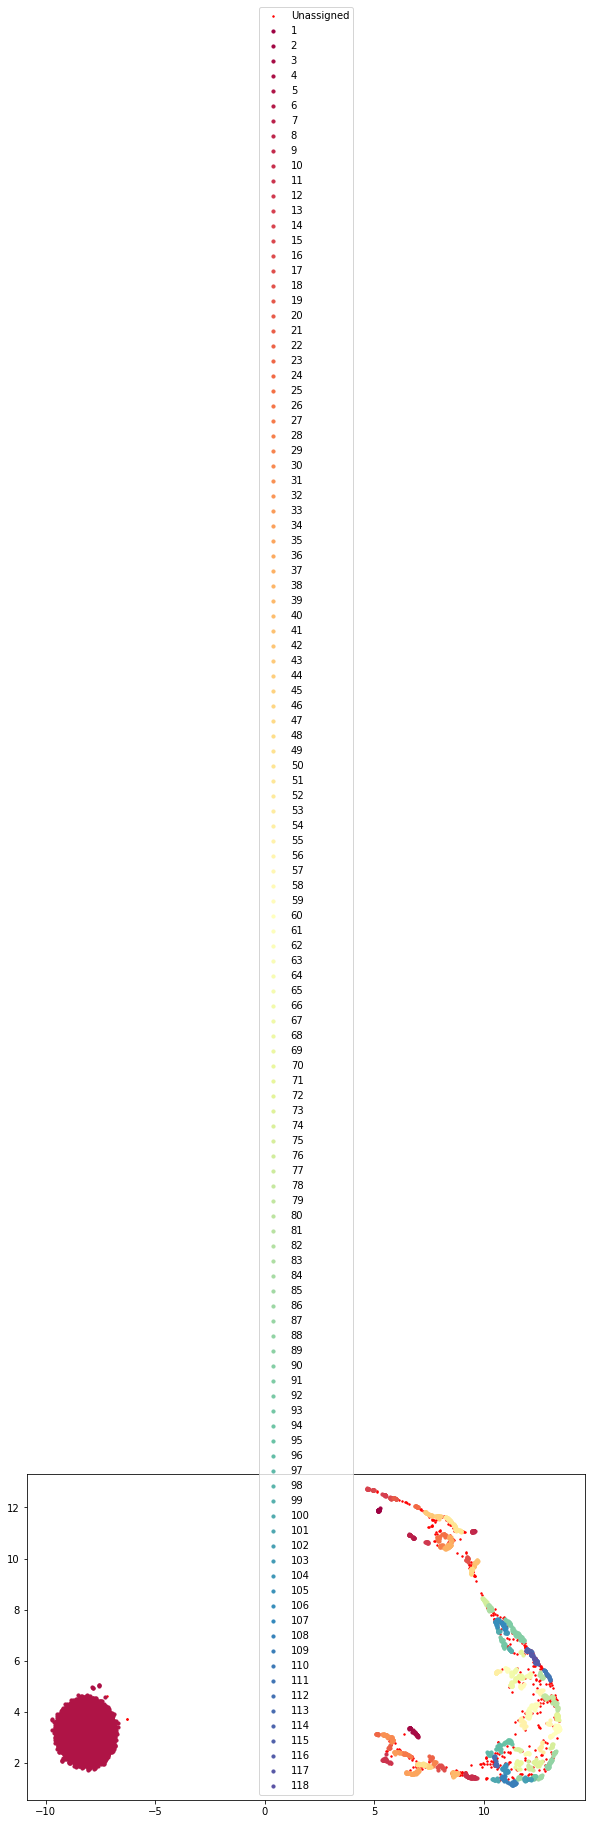

In [344]:
mpl.rcParams['figure.figsize'] = (10,6)
spec_percentile.vis_umap(legend=True)
mpl.rcParams['figure.figsize'] = (6,4)

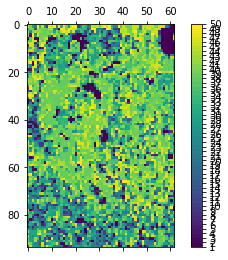

In [149]:
spec_subset_only_relevant.plot_segments()

Now we want to reproduce this using another unsupervised approach, which relies on DE masses

This will calculate all differential masses for 300 shape/Aorta pixels against background pixels on the diagonal

In [529]:
bandPixels = calc_band_pixels(spectra)
bandPixels = set(bandPixels).difference(shapePixels)

testShape = random.sample(shapePixels, 300)

masses_de, masses_de_px, masses_counter_de = calculateDiffMasses( spectra, testShape, bandPixels, storeFCs=False)

|                                                         | N/A% ETA:  --:--:--

Masses:  1000


|#########################################                |  72% ETA:   0:02:29

Masses:  6000
Masses:  6000
Masses:  6000


|#########################################################| 100% Time:  0:09:03


Found 6542 differential masses


In [530]:
masses_aorta, masses_aorta_px, masses_counter_aorta = calculateDiffMasses( spectra, testShape , testShape, storeFCs=False)

|#########################################################| 100% Time:  0:08:27


Found 3800 differential masses


In [531]:
testBg = random.sample(bgPixels, 300)

masses_bg, masses_bg_px, masses_counter_bg = calculateDiffMasses( spectra, testBg , testBg, storeFCs=False)

|                                                         |   0% ETA:   0:08:11

Masses:  3000


|#########################################################| 100% Time:  0:08:29


Found 5234 differential masses


In [548]:
print("masses_de tests", len(testShape)*len(bandPixels))
print("masses_aorta tests", len(testShape)*len(testShape))
print("masses_bg tests", len(testBg)*len(testBg))

masses_de tests 97200
masses_aorta tests 90000
masses_bg tests 90000


Given these results, the masses we are interested in are those found by masses_de, which are not in either masses_aorta or masses_bg .

In [550]:
print("masses_de", len(masses_de), masses_de.most_common(10))

print("masses_aorta", len(masses_aorta), masses_aorta.most_common(10))

print("masses_bg", len(masses_bg), masses_bg.most_common(10))

masses_de 6542 [(565.6717803179739, 53869), (609.7011735172446, 51204), (521.6820890061688, 49020), (610.6937207038828, 48369), (521.6423871187033, 47810), (819.8432638722851, 46767), (756.8760703519574, 46009), (844.8554529755678, 45988), (653.7305667165153, 45681), (477.6129939194325, 44874)]
masses_aorta 3800 [(609.7011735172446, 44724), (653.7305667165153, 44580), (609.7408754047101, 43840), (610.6937207038828, 42160), (697.7599599157861, 41982), (565.6717803179739, 41974), (521.6820890061688, 41794), (610.7334225913484, 41776), (698.7525071024243, 41556), (830.9200904751674, 40012)]
masses_bg 5234 [(521.6423871187033, 44554), (819.8432638722851, 44510), (756.8760703519574, 43756), (844.8554529755678, 42706), (843.9026076763951, 42336), (521.6820890061688, 40706), (820.8358110589234, 40174), (843.8629057889295, 39730), (566.6643275046122, 39614), (565.6717803179739, 38794)]


We now have the following sets of differential masses:


masses_de -> masses differential between aorta and background

masses_aorta -> masses differential between aorta and aorta

masses_bg -> masses differential between background and background


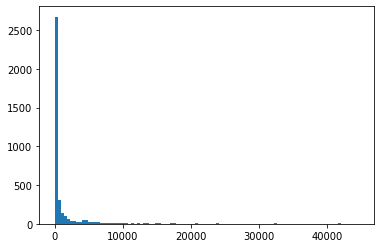

In [552]:
a=plt.hist([masses_aorta[x] for x in masses_aorta], bins=100)

It can be seen that these masses not really define the aorta well.

Hence we define validMasses, which are masses that are only differential between aorta and background, but not within aorta or background.

In [553]:
deMasses = set([x for x in masses_de])
aortaMasses = set([x for x in masses_aorta])
bgMasses = set([x for x in masses_bg])

In [554]:
print(len(deMasses), len(aortaMasses), len(bgMasses))

6542 3800 5234


There are 1059 aorta pixels and 4769 background pixels.

Masses of interest hence must be found in about 1/3 of all comparisons - 30.000!

In [583]:
validMasses = set([x for x in deMasses if masses_de[x] > 10000]).difference([x for x in aortaMasses if masses_aorta[x] > 15000])#.difference([x for x in bgMasses if masses_bg[x] > 15000])
print("Identified valid Masses", len(validMasses), "from", len(set([x for x in deMasses if masses_de[x] > 10000])), "possible ones")

Identified valid Masses 143 from 246 possible ones


In [584]:
fcMassesValid = Counter()

for x in masses_de:
    if x in validMasses:
        fcMassesValid[x] = masses_de[x]
        
print(len(fcMassesValid), fcMassesValid.most_common(5))

143 [(782.8808066418784, 28314), (615.5373509746772, 28070), (614.5051019005735, 26851), (758.9008666126994, 25218), (732.8961303227784, 23358)]


A total of 1963 such masses exists, but they are only found quite infrequently (around 300 times)...

2020-09-23 14:51:29,565  SpectraRegion  INFO: Processing Mass 782.8808066418784 with best existing mass 782.8808066418784


782.8808066418784 28314 28314


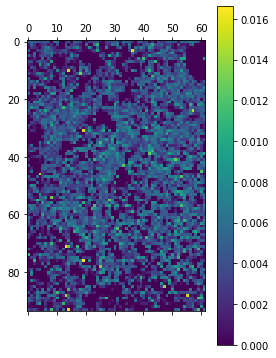

2020-09-23 14:51:29,689  SpectraRegion  INFO: Processing Mass 615.5373509746772 with best existing mass 615.5373509746772


615.5373509746772 28070 28070


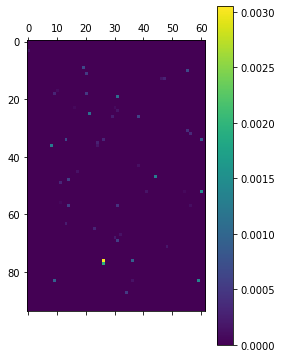

2020-09-23 14:51:29,810  SpectraRegion  INFO: Processing Mass 614.5051019005735 with best existing mass 614.5051019005735


614.5051019005735 26851 26851


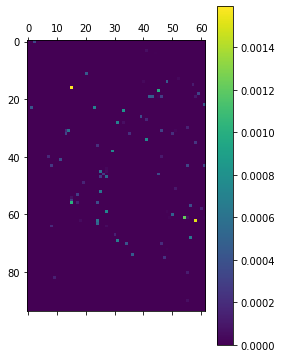

2020-09-23 14:51:29,941  SpectraRegion  INFO: Processing Mass 758.9008666126994 with best existing mass 758.9008666126994


758.9008666126994 25218 25218


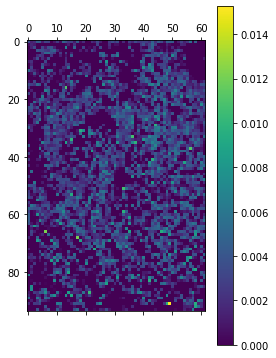

2020-09-23 14:51:30,085  SpectraRegion  INFO: Processing Mass 732.8961303227784 with best existing mass 732.8961303227784


732.8961303227784 23358 23358


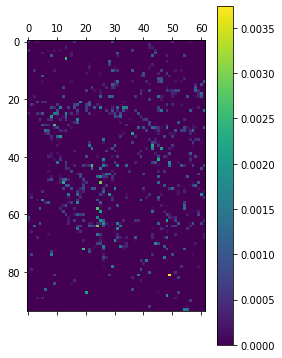

2020-09-23 14:51:30,211  SpectraRegion  INFO: Processing Mass 831.9920414367367 with best existing mass 831.9920414367367


831.9920414367367 23205 23205


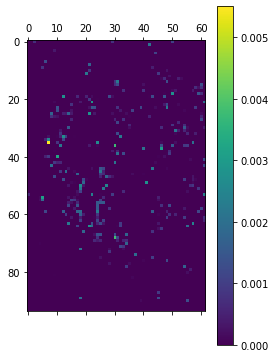

2020-09-23 14:51:30,333  SpectraRegion  INFO: Processing Mass 796.8161691422788 with best existing mass 796.8161691422788


796.8161691422788 23020 23020


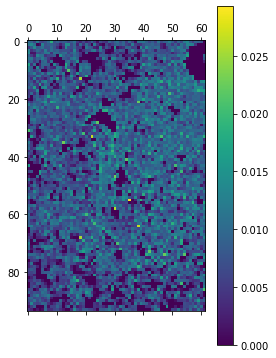

2020-09-23 14:51:30,452  SpectraRegion  INFO: Processing Mass 614.5448037880391 with best existing mass 614.5448037880391


614.5448037880391 21602 21602


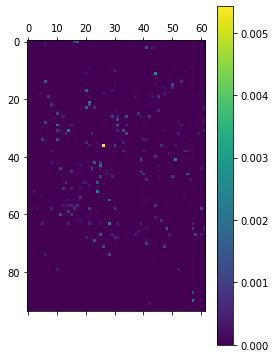

2020-09-23 14:51:30,570  SpectraRegion  INFO: Processing Mass 870.8601892654888 with best existing mass 870.8601892654888


870.8601892654888 21582 21582


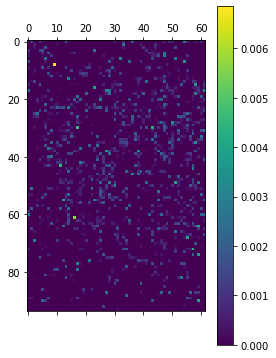

2020-09-23 14:51:30,697  SpectraRegion  INFO: Processing Mass 804.8359504103155 with best existing mass 804.8359504103155


804.8359504103155 21483 21483


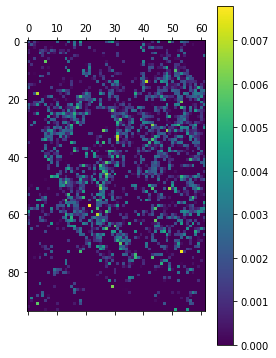

In [585]:
for x,y in fcMassesValid.most_common(10):
    print(x, y, masses_de[x])
    mi = spec_subset_de.mass_heatmap(x)

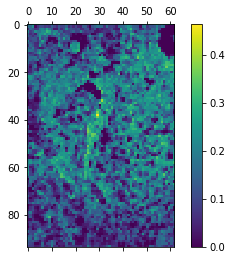

In [586]:
sc = spec_subset_de.plot_tic([x[0] for x in fcMassesValid.most_common()])

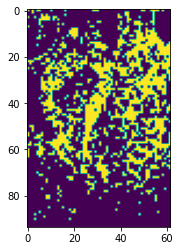

In [588]:
plt.imshow(sc > 0.2)

What can be seen is that this does not work very well ...

In [589]:
fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in fcMassesValid])
sub_peaks_count = Counter()
for x in fcMassesValid:
    sub_peaks_count[x] = masses_de[x]

sub_peaks_de = spectra[:,:,fcIndices]
sub_masses_de = sh_masses_sporig_bg[fcIndices]

sub_peaks_de.shape

(94, 62, 143)

In [590]:
spec_subset_only_relevant = SpectraRegion(sub_peaks_de, sub_masses_de)

In [591]:
spec_subset_only_relevant.calculate_similarity(mode="spectra_log")

2020-09-23 14:52:51,737  SpectraRegion  INFO: Creating C++ obj
2020-09-23 14:52:51,738  SpectraRegion  INFO: 143 (94, 62, 143)
2020-09-23 14:52:51,738  SpectraRegion  INFO: dimensions 143
2020-09-23 14:52:51,739  SpectraRegion  INFO: input dimensions (94, 62, 143)
2020-09-23 14:52:51,739  SpectraRegion  INFO: Switching to dot mode
2020-09-23 14:52:51,741  SpectraRegion  INFO: Starting calc similarity c++


143


2020-09-23 14:52:53,712  SpectraRegion  INFO: outclust dimensions (5828, 5828)
2020-09-23 14:52:53,713  SpectraRegion  INFO: Calculating spectra similarity
2020-09-23 14:52:53,869  SpectraRegion  INFO: Calculating spectra similarity done


array([[1.        , 0.9247444 , 0.9136322 , ..., 0.9177329 , 0.88550025,
        0.8865797 ],
       [0.9247444 , 1.        , 0.7229179 , ..., 0.8959392 , 0.91220176,
        0.771232  ],
       [0.9136322 , 0.7229179 , 0.99999994, ..., 0.82526916, 0.73196167,
        0.8860485 ],
       ...,
       [0.9177329 , 0.8959392 , 0.82526916, ..., 1.        , 0.9140035 ,
        0.8802265 ],
       [0.88550025, 0.91220176, 0.73196167, ..., 0.9140035 , 1.        ,
        0.81465685],
       [0.8865797 , 0.771232  , 0.8860485 , ..., 0.8802265 , 0.81465685,
        0.99999994]], dtype=float32)

In [596]:
spec_subset_only_relevant.segment(method="WARD", number_of_regions=5)

2020-09-23 14:53:13,942  SpectraRegion  INFO: Calculating clusters
2020-09-23 14:53:14,960  SpectraRegion  INFO: Calculating clusters done
2020-09-23 14:53:14,971  SpectraRegion  INFO: Calculating clusters saved


array([[5, 5, 2, ..., 2, 4, 1],
       [2, 5, 4, ..., 1, 1, 1],
       [5, 5, 5, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 5, ..., 5, 5, 5],
       [2, 2, 2, ..., 2, 5, 2]], dtype=int16)

In [ ]:
spec_subset_only_relevant.filter_clusters(method='remove_singleton')
spec_subset_only_relevant.filter_clusters(method='merge_background')
spec_subset_only_relevant.filter_clusters(method='remove_islands')

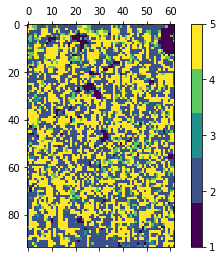

In [597]:
spec_subset_only_relevant.plot_segments()

In [598]:
spec_subset_only_relevant.segment(method="UMAP_DBSCAN",number_of_regions=None,min_cluster_size=5, min_samples=None, n_neighbors=15)

2020-09-23 14:58:08,009  SpectraRegion  INFO: Calculating clusters
2020-09-23 14:58:08,017  SpectraRegion  INFO: UMAP reduction


Elem Matrix (5828, 143)


2020-09-23 14:58:15,029  SpectraRegion  INFO: HDBSCAN reduction
2020-09-23 14:58:15,123  SpectraRegion  INFO: Calculating clusters done
2020-09-23 14:58:15,128  SpectraRegion  INFO: Calculating clusters saved


array([[ 55, 176,  67, ..., 131, 162,   2],
       [ -1,  29, 190, ...,   2,   2,   2],
       [ 36,  14,  14, ...,   2,   2,   2],
       ...,
       [ -1,  -1, 139, ...,  67, 124,  -1],
       [ 85,  -1,  -1, ...,  -1,  -1, 116],
       [ 76,  85, 154, ..., 139, 175, 151]], dtype=int16)

0.0 0.975
5828
505


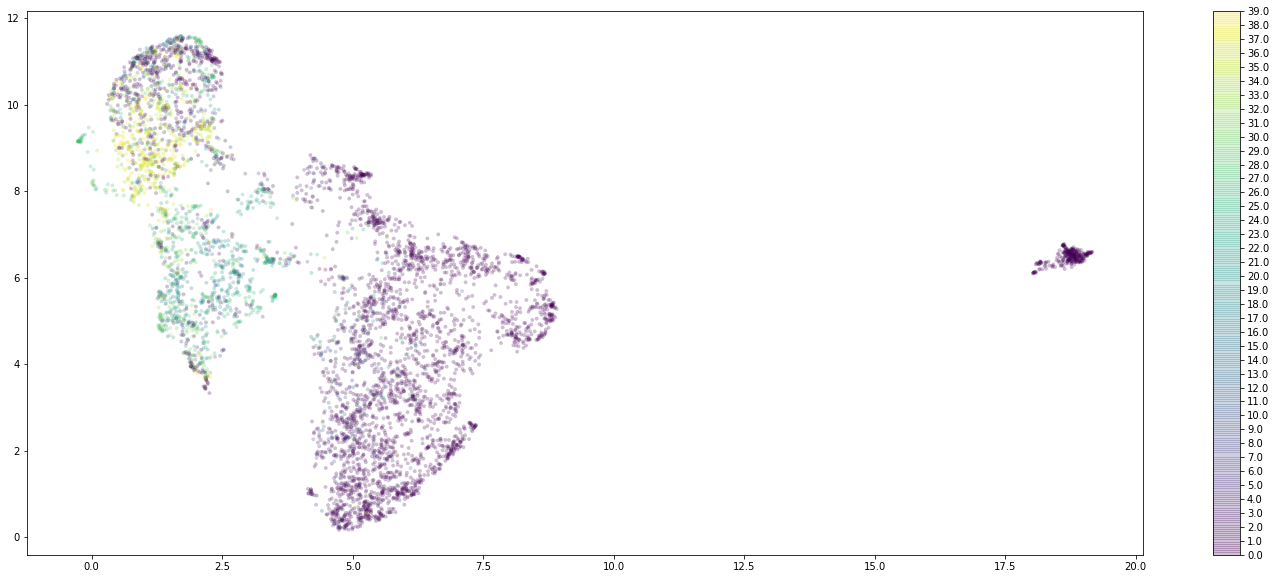

In [599]:
projection = spec_subset_only_relevant.dimred_elem_matrix

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True,gen_min_span_tree=True).fit(spec_percentile.dimred_elem_matrix)

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

cluster_labels = [np.argmax(x) for x in soft_clusters]

uniqueLabels = sorted(set(cluster_labels))
numLabels = len(cluster_labels)

cluster_colors = [x/len(uniqueLabels) for x in cluster_labels]

mpl.rcParams['figure.figsize'] = (25,10)
sp = plt.scatter(*projection.T, s=15, linewidth=0, c=cluster_colors, cmap="viridis", alpha=0.25)

valid_vals = np.unique(cluster_colors)
min_ = min(valid_vals)
max_ = max(valid_vals)

print(min_, max_)

positions = np.linspace(min_, max_, len(valid_vals))
val_lookup = dict(zip(positions, valid_vals))

def formatter_func(x, pos):
    'The two args are the value and tick position'
    val = val_lookup[x] * len(valid_vals)
    return val

formatter = plt.FuncFormatter(formatter_func)
plt.colorbar(sp, ticks=positions, format=formatter, spacing='proportional')

mpl.rcParams['figure.figsize'] = (6,4)

print(numLabels)
print(sum(clusterer.labels_ == -1))


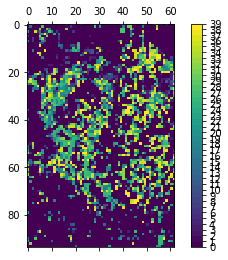

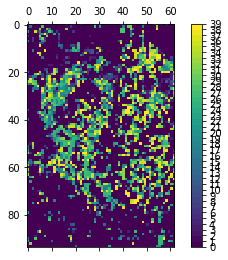

In [600]:
hdblabels = np.reshape(cluster_labels, (94,62))
spec_percentile.plot_array(plt.figure(), hdblabels)

In [ ]:
#spectra_intra = imze.normalize_region_array(sh_sporig, normalize="intra_median")
#sh_sporig_norm = imze.normalize_region_array(spectra_intra, normalize="inter_median")

In [ ]:
calculateDiffMassesEmpire

In [626]:
bandPixels = calc_band_pixels(spectra)
bandPixels = set(bandPixels).difference(shapePixels)

testShape = random.sample(shapePixels, 300)

masses_de = calculateDiffMassesEmpire( spectra, testShape, bandPixels)

|                                                         |   0% ETA:   3:18:54

KeyboardInterrupt: 

324

In [ ]:
specbg_sh = SpectraRegion(spectra_intra_inter_max, imze.mzValues)

In [ ]:
def calc_band_pixels(spre):
    
    band_pixels = set()
    
    xmax = spre.shape[0]
    ymax = spre.shape[1]
    
    p2 = np.array([xmax, ymax])
    p1 = np.array([0,0])
    
    for i in range(spre.shape[0]):
        for j in range(spre.shape[1]):
            
            p3 = np.array([i,j])
            d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
            
            if d < 2:
                band_pixels.add((i,j))
                
    return band_pixels
    

In [ ]:
spectra = np.copy(sh_sporig_bg)
#copy specbg_sh

In [ ]:
spectra.shape

In [ ]:
global_fcs = Counter()
scalingFactor = 1

fcMasses = set()
fcMassesCounter = Counter()
masses2fcs = defaultdict(list)

spectra_band_pixels = calc_band_pixels(spectra)

stdMul = 8

bar = progressbar.ProgressBar(widgets=[
        progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
    ])

for k in bar(range(spectra.shape[0])):
    for l in range(spectra.shape[1]):
        

        for i in range(spectra.shape[0]):
            for j in range(spectra.shape[1]):
                
                if (k,l) == (i,j):
                    continue
                
                    
                if not (k,l) in spectra_band_pixels or not (i,j) in spectra_band_pixels:
                    continue

                fcs = np.log( (spectra[i][j]+(1.0/scalingFactor)) / (spectra[k][l] +(1.0/scalingFactor)) )
                
                meanFCs = np.mean(fcs)
                stdFCs = np.std(fcs)
                
                maxFC = meanFCs + stdMul*stdFCs
                minFC = meanFCs - stdMul*stdFCs
                                    
                if len(fcMassesCounter) % 1000 == 0:
                    print("Masses: ", len(fcMassesCounter))
                
                for i, x in enumerate(fcs):
                    if x < minFC or x > maxFC:
                        
                        fcMass = imze.mzValues[i]
                        
                        masses2fcs[fcMass].append(x)
                        fcMassesCounter[fcMass] += 1



                

In [ ]:
mcmasses = [x[0] for x in fcMassesCounter.most_common(10000)]
print("mcmasses", len(mcmasses))

fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in mcmasses])
sub_peaks = spectra[:,:,fcIndices]
sub_masses = imze.mzValues[fcIndices]

In [ ]:
spec_subset = SpectraRegion(sub_peaks, sub_masses, "subset_masses")

In [ ]:
print(
    manual_mask[0,0],
    manual_mask[40,20]

)

In [ ]:
trueRate = 0
for value, label in zip(values_test, classes_test):
    retVal = clf.predict_proba([value])[0]
    pred_label = np.argmax(retVal)
    #print(label, pred_label, label==pred_label)
    
    if label==pred_label:
        trueRate += 1
        
print(trueRate, trueRate / len(classes_test))

In [ ]:
trues = np.zeros((sub_peaks.shape[0], sub_peaks.shape[1]))

trueEvals = 0

for x in range(0, sub_peaks.shape[0]):
    for y in range(0, sub_peaks.shape[1]):
        
        
        retVal = clf.predict_proba([ sub_peaks[x,y,:] ])[0]
        pred_label = np.argmax(retVal)
        
        if pred_label == 1:
            trues[x,y] = 1
            
print(trueEvals, sub_peaks.shape[0]*sub_peaks.shape[1], trueEvals / (sub_peaks.shape[0]*sub_peaks.shape[1]))
plt.imshow(trues)
        

In [ ]:
for x,y in fcMassesCounter.most_common(10):
    spec_subset.mass_heatmap(x)

In [ ]:
specbg_sh.calculate_similarity(mode="spectra")

In [ ]:
specbg_sh.segment(method="WARD", number_of_regions=15)

In [ ]:
specbg_sh.plot_segments()

In [ ]:
sh_masses_sporig_bg.shape

In [ ]:
sh_sporig_bg.shape

In [ ]:
spectra = sh_sporig_bg
spectra.shape

In [ ]:

def calculateDiffMasses( inSpectra, testPixels, testAgainstPixels, storeFCs = False):

    global_fcs = Counter()
    scalingFactor = 1000

    fcMassesCounter = Counter()
    masses2fcs = defaultdict(list)

    stdMul = 8

    bar = progressbar.ProgressBar(widgets=[
            progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
        ])

    for (k,l) in bar(testPixels):       
        
        pixelMasses = set()

        for i in range(inSpectra.shape[0]):
            for j in range(inSpectra.shape[1]):

                if (k,l) == (i,j):
                    continue

                if not (i,j) in testAgainstPixels:
                    continue


                fcs = np.log( (inSpectra[i][j]+(1.0/scalingFactor)) / (inSpectra[k][l] +(1.0/scalingFactor)) )

                meanFCs = np.mean(fcs)
                stdFCs = np.std(fcs)

                maxFC = meanFCs + stdMul*stdFCs
                minFC = meanFCs - stdMul*stdFCs

                if len(fcMassesCounter) > 0 and len(fcMassesCounter) % 1000 == 0:
                    print("Masses: ", len(fcMassesCounter))

                for ifc, x in enumerate(fcs):                        
                    if x < minFC or x > maxFC:
                        fcMass = imze.mzValues[ifc]
                        
                        if not fcMass in pixelMasses:
                            fcMassesCounter[fcMass] += 1
                            pixelMasses.add(fcMass)
         
    print("Found", len(fcMassesCounter), "differential masses")
        
    if storeFCs:
        bar = progressbar.ProgressBar(widgets=[
                progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
            ])

        
        for (k,l) in bar(testPixels):       

            for i in range(inSpectra.shape[0]):
                for j in range(inSpectra.shape[1]):

                    if (k,l) == (i,j):
                        continue

                    if not (i,j) in testAgainstPixels:
                        continue


                    fcs = np.log( (inSpectra[i][j]+(1.0/scalingFactor)) / (inSpectra[k][l] +(1.0/scalingFactor)) )

                    meanFCs = np.mean(fcs)
                    stdFCs = np.std(fcs)

                    maxFC = meanFCs + stdMul*stdFCs
                    minFC = meanFCs - stdMul*stdFCs

                    for ifc, x in enumerate(fcs):

                        fcMass = imze.mzValues[ifc]

                        if fcMass in fcMassesCounter:
                            masses2fcs[fcMass].append(x)                      


    return fcMassesCounter, masses2fcs

                

In [ ]:
bandPixels = calc_band_pixels(spectra)
bandPixels = set(bandPixels).difference(shapePixels)

testShape = random.sample(shapePixels, 300)

masses_de, masses_counter_de = calculateDiffMasses( sh_sporig_bg, testShape, bandPixels, storeFCs=False)

In [ ]:
testShape = random.sample(shapePixels, 300)

masses_aorta, masses_counter_aorta = calculateDiffMasses( sh_sporig_bg, testShape , testShape, storeFCs=False)

In [ ]:
tm, tmc = masses_de.most_common(1)[0]
print(tm, tmc)

In [ ]:
plt.hist(masses_counter_aorta[tm], histtype="step", cumulative=True)

In [ ]:
testBg = random.sample(bgPixels, 300)

masses_bg, masses_counter_bg = calculateDiffMasses( sh_sporig_bg, testBg , testBg, storeFCs=False)

In [ ]:
deMasses = set()

for x in masses_de:
    
    if x in masses_bg:
        continue
        
    if x in masses_aorta:
        continue
        
    deMasses.add(x)

print(len(deMasses))

In [ ]:
mcmasses = [x[0] for x in fcMassesCounter.most_common(10000)]
print("mcmasses", len(mcmasses))

fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in mcmasses])
sub_peaks = spectra[:,:,fcIndices]
sub_masses = imze.mzValues[fcIndices]

In [ ]:
masses_de.most_common(10)

In [ ]:
fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in deMasses])
sub_peaks_count = Counter()
for x in deMasses:
    sub_peaks_count[x] = masses_de[x]

sub_peaks_de = spectra[:,:,fcIndices]
sub_masses_de = imze.mzValues[fcIndices]

spec_subset_de = SpectraRegion(sub_peaks_de, sub_masses_de, "subset_masses")

In [ ]:
spec_subset_de = SpectraRegion(sub_peaks_de, sub_masses_de, "subset_masses")

In [ ]:
for x,y in sub_peaks_count.most_common(15):
    print(x,y)
    spec_subset_de.mass_heatmap(x)

In [ ]:
spec_subset_de.plot_tic()

In [ ]:
len(fcMassesCounter)

In [ ]:
mcmasses = [x[0] for x in fcMassesCounter.most_common(10000)]
len(mcmasses)

In [ ]:
fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in mcmasses])

In [ ]:
sub_peaks = spectra[:,:,fcIndices]
sub_masses = imze.mzValues[fcIndices]

In [ ]:
plot_coords(sub_peaks, [(20,15), (40,15), (60,15), (80,15)], range(0,len(sub_masses)), sub_masses)

In [ ]:
sub_masses

In [ ]:
def calc_similarity( mat ):

    #mat = np.array(sub_peaks, copy=True)

    bar = progressbar.ProgressBar(widgets=[
            progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
        ])    
    elems = mat.shape[0]*mat.shape[1]

    result = np.zeros((elems, elems))

    meanMat = np.zeros((elems, elems))
    stdMat = np.zeros((elems, elems))

    print("Calculating cosine similarity Start", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    for i in bar(range(0, mat.shape[0])):
        for j in range(0, mat.shape[1]):
            idxI = i*mat.shape[1] + j
            matIJ = mat[i,j,:]

            for k in range(0, mat.shape[0]):
                for l in range(0, mat.shape[1]):
                    idxJ = k*mat.shape[1] + l
                    matKL = mat[k,l,:]

                    if idxJ == idxI:
                        result[idxI, idxJ] = len(matIJ)
                        continue

                    if idxJ < idxJ:
                        continue

                    fcs = np.log((matIJ+0.1) / (matKL+0.1))
                    #fcs = sorted(fcs)

                    meanFCs = np.mean(fcs)
                    stdFCs = np.std(fcs)

                    meanMat[idxI, idxJ] = meanFCs
                    stdMat[idxI, idxJ] = stdFCs

                    maxFC = meanFCs + 2*stdFCs
                    minFC = meanFCs - 2*stdFCs
                    
                    #print(min(fcs), max(fcs), minFC, maxFC)

                    kfcs = fcs[fcs <= maxFC]
                    kfcs = kfcs[minFC <= kfcs]

                    sims = len(kfcs)

                    result[idxI, idxJ] = sims
                    result[idxJ, idxI] = sims

    print("Calculating cosine similarity End", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

    return result, meanMat, stdMat
            
            

In [ ]:
sub_peaks.shape

In [ ]:
subpeak_sim, subpeak_mean, subpeak_std = calc_similarity(sub_peaks)

In [ ]:
import pickle

In [ ]:
with open("subpeak_sim.pickle", 'wb') as fout:
    pickle.dump( (sub_peaks, subpeak_sim, subpeak_mean, subpeak_std), file=fout)

In [ ]:
with open("subpeak_sim.pickle", "rb") as fin:
    (sub_peaks, subpeak_sim, subpeak_mean, subpeak_std) = pickle.load(fin)

In [ ]:
orig_subpeak_sim = np.array(subpeak_sim, copy=True)

In [ ]:
np.max(subpeak_sim)

In [ ]:
subpeak_sim_norm = subpeak_sim  /np.max(subpeak_sim)

In [ ]:
np.max(subpeak_sim_norm)

In [ ]:
plt.imshow(subpeak_sim)

In [ ]:
plt.imshow(subpeak_sim_norm)

In [ ]:
spec_std = SpectraRegion(sub_peaks, sub_masses, "subset_masses")

In [ ]:
spec_std.calculate_similarity(mode="spectra")

In [ ]:
spec_std.spectra_similarity = subpeak_sim_norm

In [ ]:
spec_std.segment(method="WPGMA", number_of_regions=5)

In [ ]:
spec_std.plot_segments()

In [ ]:
spec_std.segment(method="UMAP_DBSCAN",n_neighbors=5, min_samples=10, min_cluster_size=20)

mpl.rcParams['figure.figsize'] = (10,6)
spec_std.vis_umap(legend=False)
mpl.rcParams['figure.figsize'] = (6,4)

spec_std.plot_segments()

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
res = spec_std.plot_tic()

In [ ]:
res

In [ ]:
pdarr = pd.DataFrame(spec_std.elem_matrix / np.max(spec_std.elem_matrix))

In [ ]:
sns.clustermap(pdarr, col_cluster=False, row_cluster=True)

In [ ]:
spec_subset = SpectraRegion(sub_peaks, sub_masses, "subset_masses")

In [ ]:
spec_subset.calculate_similarity(mode="spectra_log")

In [ ]:
spec_subset.segment(method="CENTROID", number_of_regions=15)

In [ ]:
spec_subset.plot_segments()

In [ ]:
spec_subset.filter_clusters(method='remove_singleton')
spec_subset.filter_clusters(method='merge_background')
spec_subset.filter_clusters(method='remove_islands')

In [ ]:
spec_subset.plot_segments()

In [ ]:
spec_subset.segment(method="UMAP_DBSCAN", n_neighbors=5, min_samples=10, min_cluster_size=20)

In [ ]:
spec_subset.segment(method="UMAP_DBSCAN", n_neighbors=5, min_samples=10, min_cluster_size=20)

mpl.rcParams['figure.figsize'] = (10,6)
spec_subset.vis_umap(legend=False)
mpl.rcParams['figure.figsize'] = (6,4)

spec_subset.plot_segments()

In [ ]:
spec_subset.plot_segments()

In [ ]:
spec_subset.filter_clusters(method='remove_singleton')
spec_subset.filter_clusters(method='merge_background')
spec_subset.filter_clusters(method='remove_islands')

In [ ]:
spec_subset.plot_segments()

In [ ]:
def calc_dot_sim( mat ):
    
    bar = progressbar.ProgressBar()
    
    elems = mat.shape[0]*mat.shape[1]
    
    result = np.zeros((elems, elems))
    mats = np.array(mat, copy=True)
    
    def normalized(a, axis=-1, order=2):
        l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
        l2[l2==0] = 1
        return a / np.expand_dims(l2, axis)
    
    print("Normalizing Matrix Start", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    mats = normalized(mat,2)
    print("Normalizing Matrix End", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
        
    print("Calculating cosine similarity Start", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    for i in bar(range(0, mats.shape[0])):
        for j in range(0, mats.shape[1]):
            idxI = i*mats.shape[1] + j
            
            for k in range(0, mats.shape[0]):
                for l in range(0, mat.shape[1]):
                    idxJ = k*mats.shape[1] + l
                    
                    if idxJ == idxI:
                        result[idxI, idxJ] = 1
                        continue
                    
                    if idxJ < idxJ:
                        continue
                        
                    cosSim = np.dot(mats[i,j,:], mats[k,j,:])
                    result[idxI, idxJ] = cosSim
                    result[idxJ, idxJ] = cosSim
                    
    print("Calculating cosine similarity End", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
                    
    return result
            
            

In [ ]:
npcos = calc_dot_sim( sh_array )

In [ ]:
spec_sh.segment(method="WARD", number_of_regions=15)

In [ ]:
spec_sh.plot_segments()

In [ ]:
spec_sh.filter_clusters(method='remove_singleton')
#spec_sh.filter_clusters(method='merge_background')
#spec_sh.filter_clusters(method='remove_islands')

In [ ]:
spec_sh.plot_segments()

In [ ]:
plt.imshow(sh_array[:,:,100])

In [ ]:
plt.figure(figsize=(20, 6))
mzvals = range(0,len(refSpec))
plt.plot(mzvals, refSpec, label="30,1")

for idx in i2sp:
    plt.plot(mzvals, i2sp[idx], label="spec {} shifted".format(idx))


plt.legend()

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(imze.mzValues, spec.region_array[40,40])

In [ ]:
spec32, spec32Idx, origCoords = imze.get_pixel_spectrum(2, (3,2))

In [ ]:
spec32Idx, origCoords

In [ ]:
ridx = imze.get_region_index_array(2)

In [ ]:
ridx[0:5,0:5]

In [ ]:
[x for x in imze.parser.coordinates if x[0] == 693 and x[1] == 317]

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(imze.mzValues, spec32)

In [ ]:
spec.calculate_similarity(mode="spectra_log_dist")

In [ ]:
import progressbar

bar = progressbar.Bar()

for x in bar(range(0,10)):
    sleep(1)